In [50]:
import pandas as pd 
import numpy as np
import re

##LDA stuff
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

##cleaning stuff
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import CoherenceModel

##plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns

In [51]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [52]:
def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    return tokens

In [53]:
def remove_non_english_words(text, valid_words):
    tokens = word_tokenize(text)
    ans = [w for w in tokens if w.lower() in valid_words]
    return ' '.join(ans)

def remove_stopwords(text):
    tokens = word_tokenize(text)
    ans = [w for w in tokens if w.lower() not in stop_words]
    return ' '.join(ans)

In [54]:
df_village = pd.read_csv('../../../data/processed/cleaned_village-hotel-changi-by-far-east-hospitality.csv')
df_park = pd.read_csv('../../../data/processed/cleaned_park-regis.csv')
df_grand = pd.read_csv('../../../data/processed/cleaned_grand-mercure-sg-roxy.csv')
df_paradox = pd.read_csv('../../../data/processed/cleaned_paradox-sg-merchant-court.csv')
df_crown = pd.read_csv('../../../data/processed/cleaned_crowne-plaza.csv')


df_combi = pd.concat([df_village, df_park, df_grand, df_paradox, df_crown])

In [55]:
##filter for year >= 2015
df_filtered = df_combi[df_combi['year'] >= 2015]

##preprocess text
nltk.download('stopwords')
nltk.download('words')
# Get the list of valid English words
english_words = set(words.words())
# set stopwords
sw = stopwords.words('english')
sw.extend(['regis', 'park_regis', 'changi', 'far_east', 'east_hospitality', 'village', 'grand_mercure', 'mercure', 'roxy',
          'paradox', 'merchant', 'merchant_court', 'crowne', 'crowne_plaza', 'crown', 'plaza', 'clark', 'quay', 'marina'])
stop_words = set(sw)
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## Stemmed

In [56]:
df_filtered['stem_review'] = df_filtered['stem_review'].apply(remove_stopwords)
df_filtered['stem_review'] = df_filtered['stem_review'].apply(remove_non_english_words, valid_words=english_words)
df_filtered['stem_tokens'] = df_filtered['stem_review'].apply(preprocess)

In [57]:
##Generate LDA dictionary and corpus
stem_dict = corpora.Dictionary(df_filtered['stem_tokens'])
stem_corpus = [stem_dict.doc2bow(text) for text in df_filtered['stem_tokens']]

In [24]:
## find best_coherence (Don't run, takes too long to run):
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    stem_ldamodel = lda(stem_corpus, num_topics=i, id2word=stem_dict, passes=15)
    
    stem_coherence = CoherenceModel(model=stem_ldamodel, texts=df_filtered['stem_tokens'], dictionary=stem_dict, coherence='c_v')
    lda_coherence = stem_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

The coherence score at topic 2 is 0.41381763755042256
The coherence score at topic 3 is 0.4094399976985413


KeyboardInterrupt: 

In [58]:
## Use 5 topics as determined by coherence
lda = gensim.models.ldamodel.LdaModel
stem_ldamodel = lda(stem_corpus, num_topics=6, id2word=stem_dict, passes=15)

In [59]:
# For all stemmed data
topics_stem = stem_ldamodel.show_topics(formatted=False, num_words=20)
data_flat_stem = [word for word_list in df_filtered['stem_tokens'] for word in word_list]

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_12140\3134060863.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')


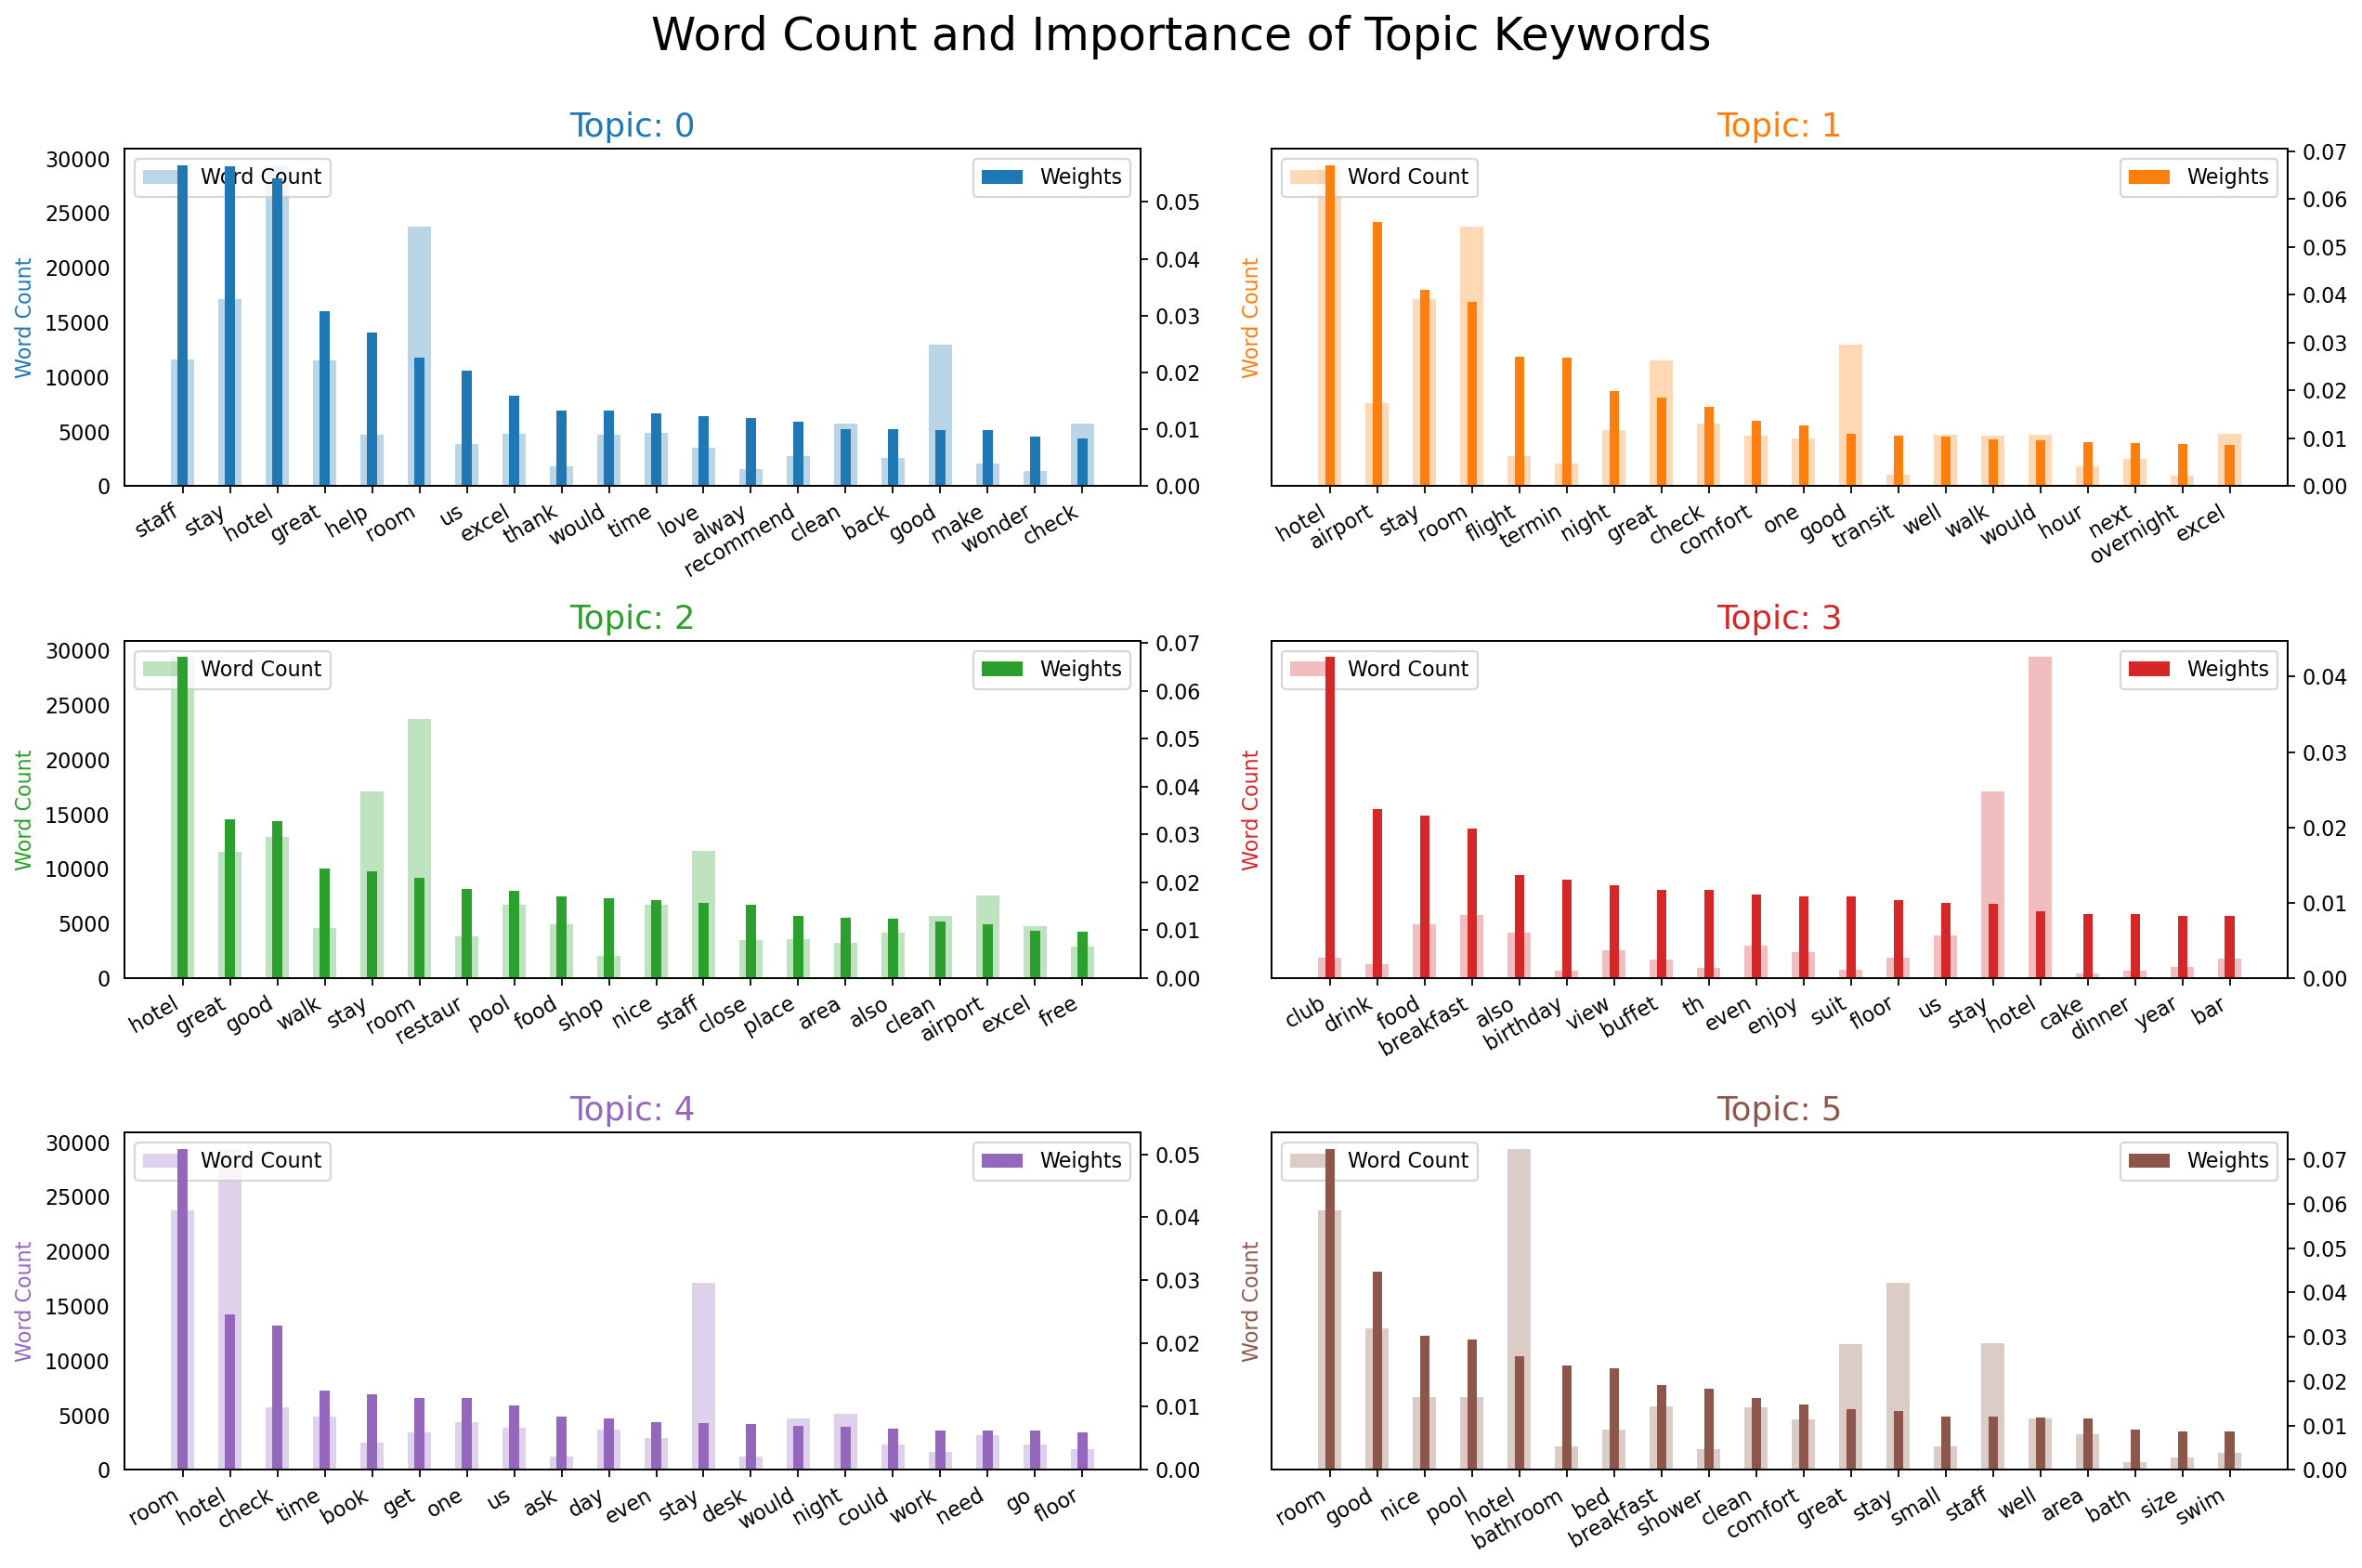

In [60]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For all topics
plot_word_count_importance(topics_stem, data_flat_stem, 'Word Count and Importance of Topic Keywords')

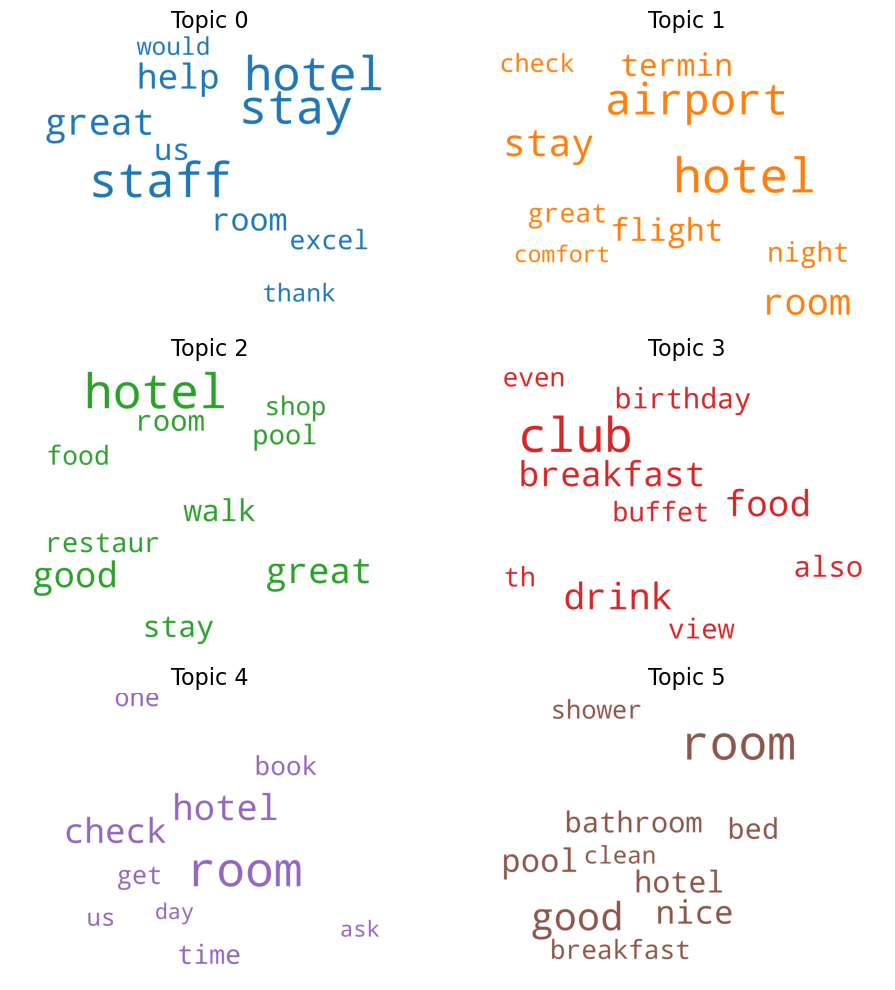

In [61]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the dataset
clouds_pre = []

for i in range(6):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(stem_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Plot the WordClouds for all topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [62]:
vis = pyLDAvis.gensim.prepare(topic_model=stem_ldamodel, corpus=stem_corpus, dictionary=stem_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Lemmatized

In [63]:
df_filtered['lem_review'] = df_filtered['lem_review'].apply(remove_stopwords)
df_filtered['lem_review'] = df_filtered['lem_review'].apply(remove_non_english_words, valid_words=english_words)
df_filtered['lem_tokens'] = df_filtered['lem_review'].apply(preprocess)

In [64]:
## Generate LDA dictionary and corpus
lem_dict = corpora.Dictionary(df_filtered['lem_tokens'])
lem_corpus = [lem_dict.doc2bow(text) for text in df_filtered['lem_tokens']]

In [33]:
## find best_coherence (Don't run, takes too long to run):
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    lem_ldamodel = lda(lem_corpus, num_topics=i, id2word=lem_dict, passes=15)
    
    lem_coherence = CoherenceModel(model=lem_ldamodel, texts=df_filtered['lem_tokens'], dictionary=lem_dict, coherence='c_v')
    lda_coherence = lem_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

The coherence score at topic 2 is 0.3752323316073417
The coherence score at topic 3 is 0.3951180034480335
The coherence score at topic 4 is 0.39575564516896355
The coherence score at topic 5 is 0.4168651531640156
The coherence score at topic 6 is 0.4251517182507669


In [65]:
## Use 6 topics as determined by coherence
lda = gensim.models.ldamodel.LdaModel
lem_ldamodel = lda(lem_corpus, num_topics=6, id2word=lem_dict, passes=15)

In [66]:
# For All
topics_lem = lem_ldamodel.show_topics(formatted=False)
data_flat_lem = [word for word_list in df_filtered['lem_tokens'] for word in word_list]

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_12140\613203038.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')


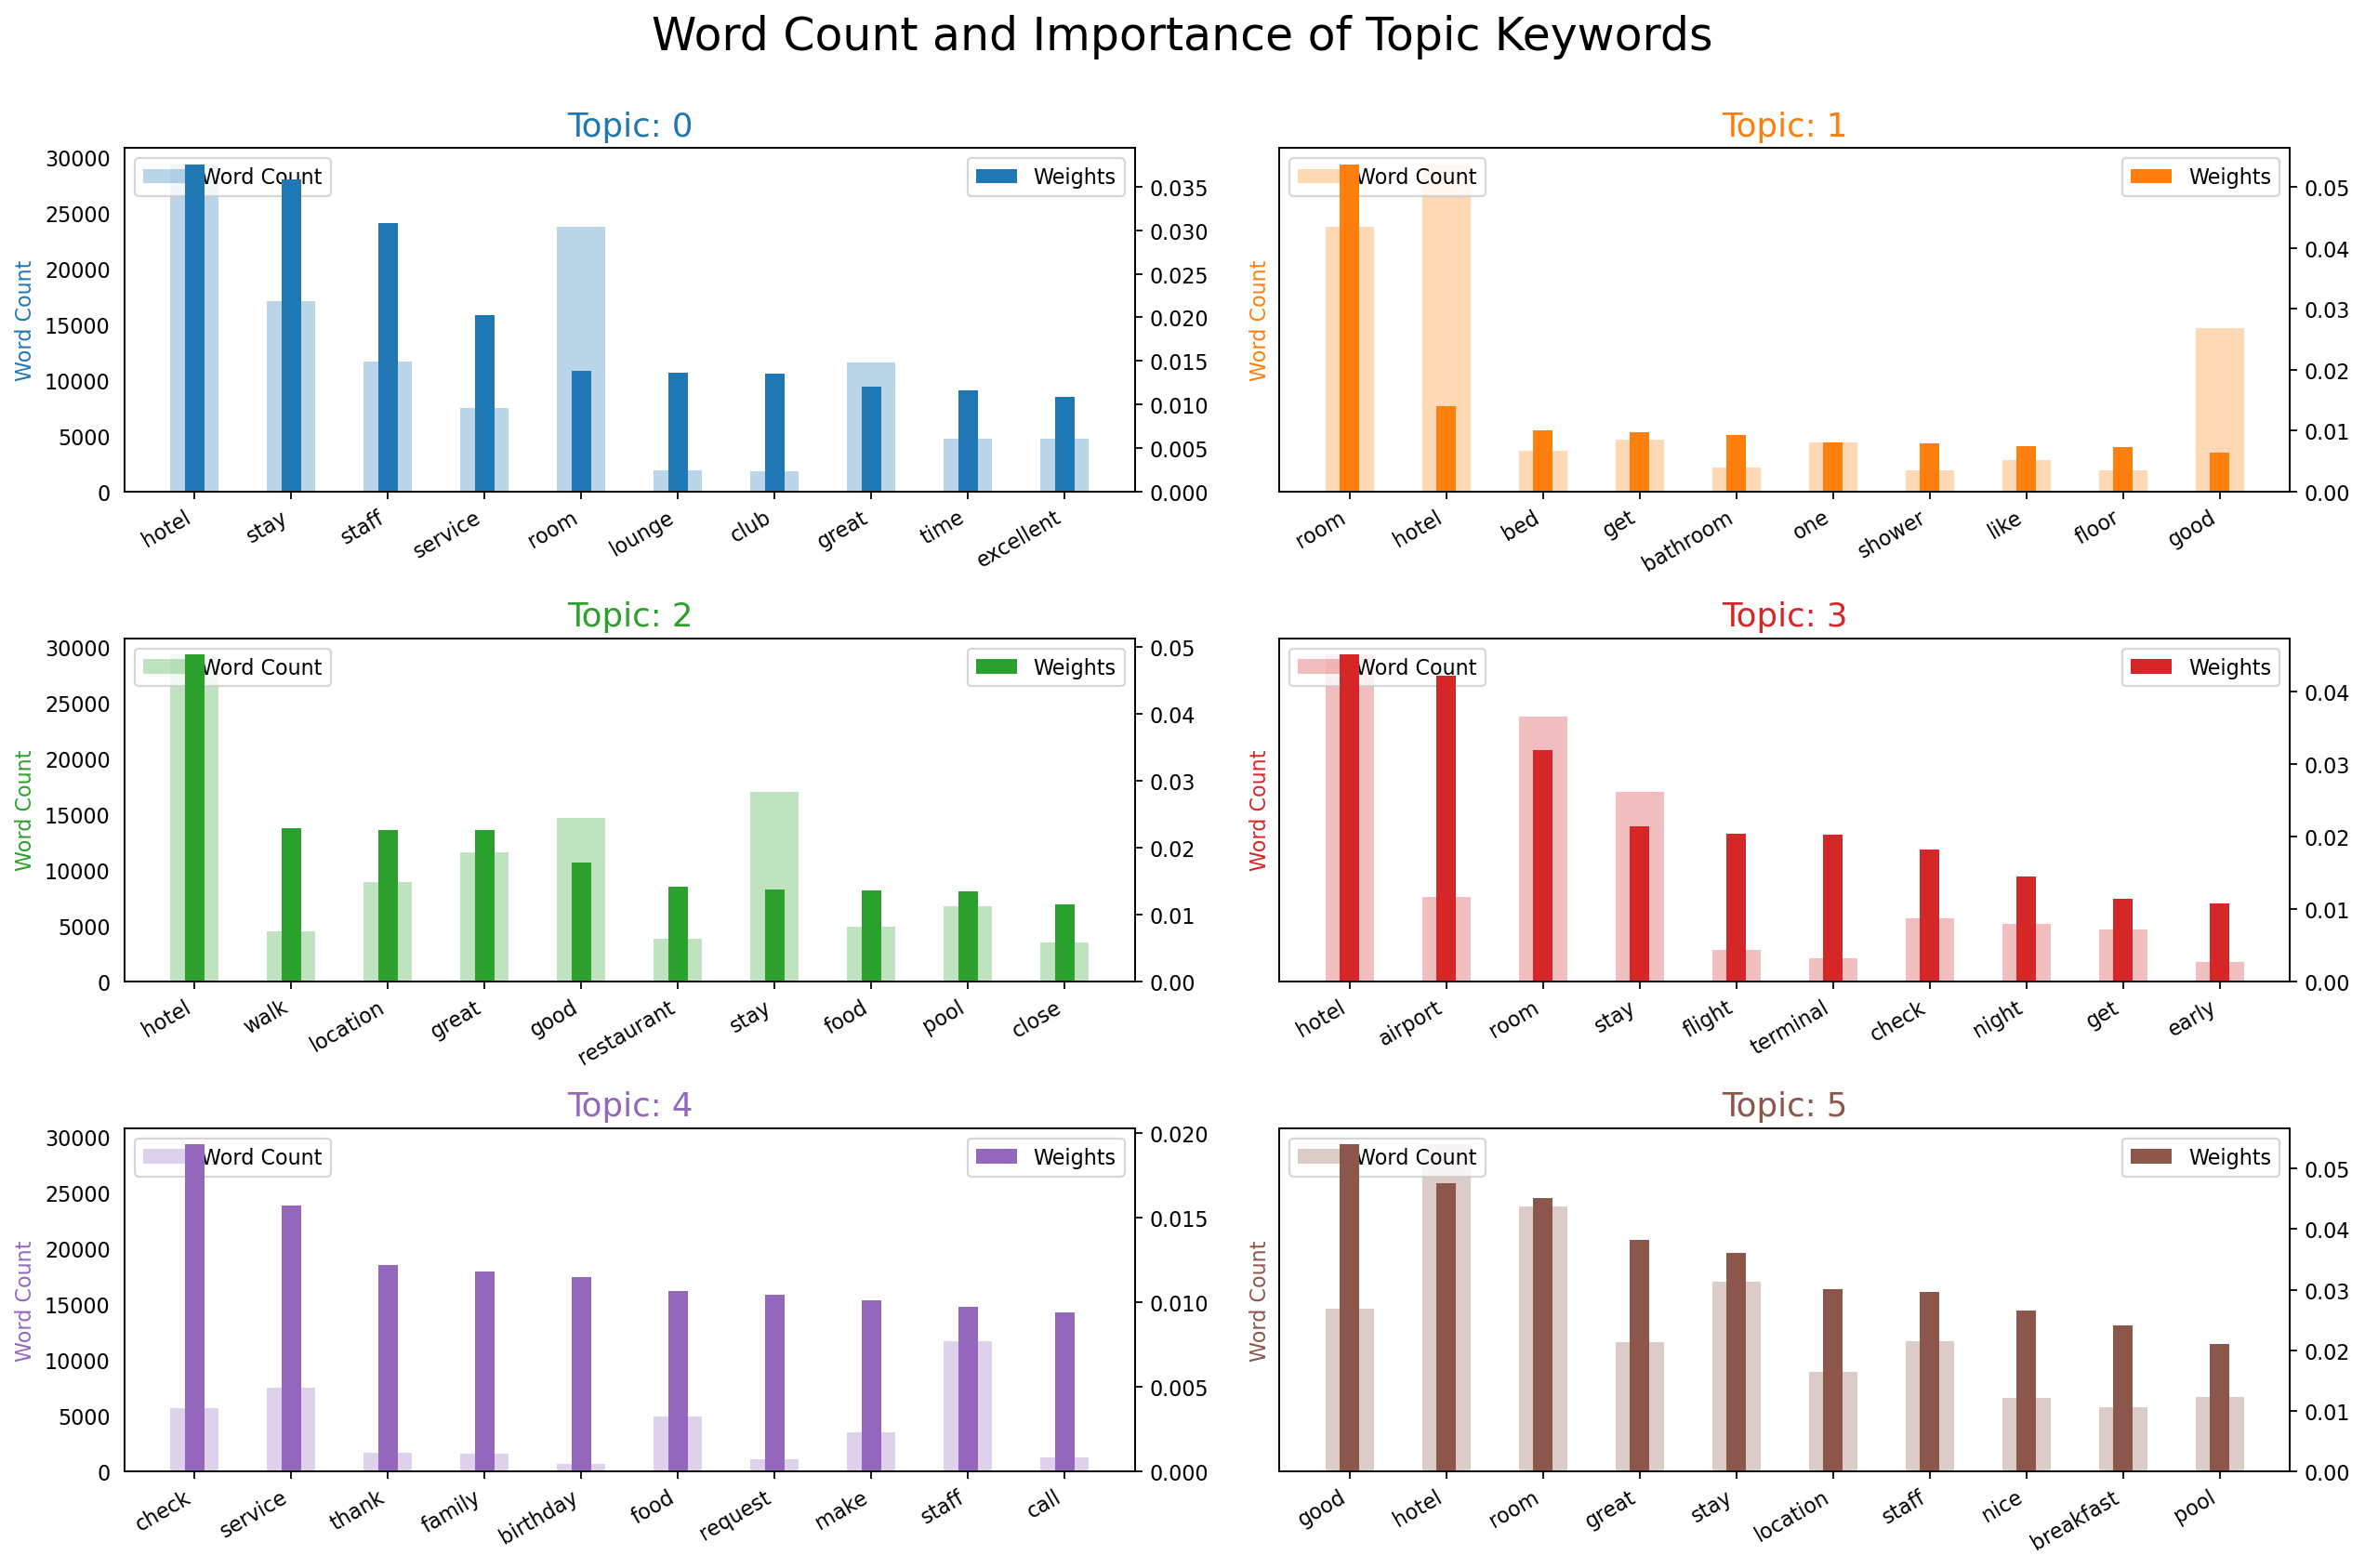

In [67]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For all topics
plot_word_count_importance(topics_lem, data_flat_lem, 'Word Count and Importance of Topic Keywords')

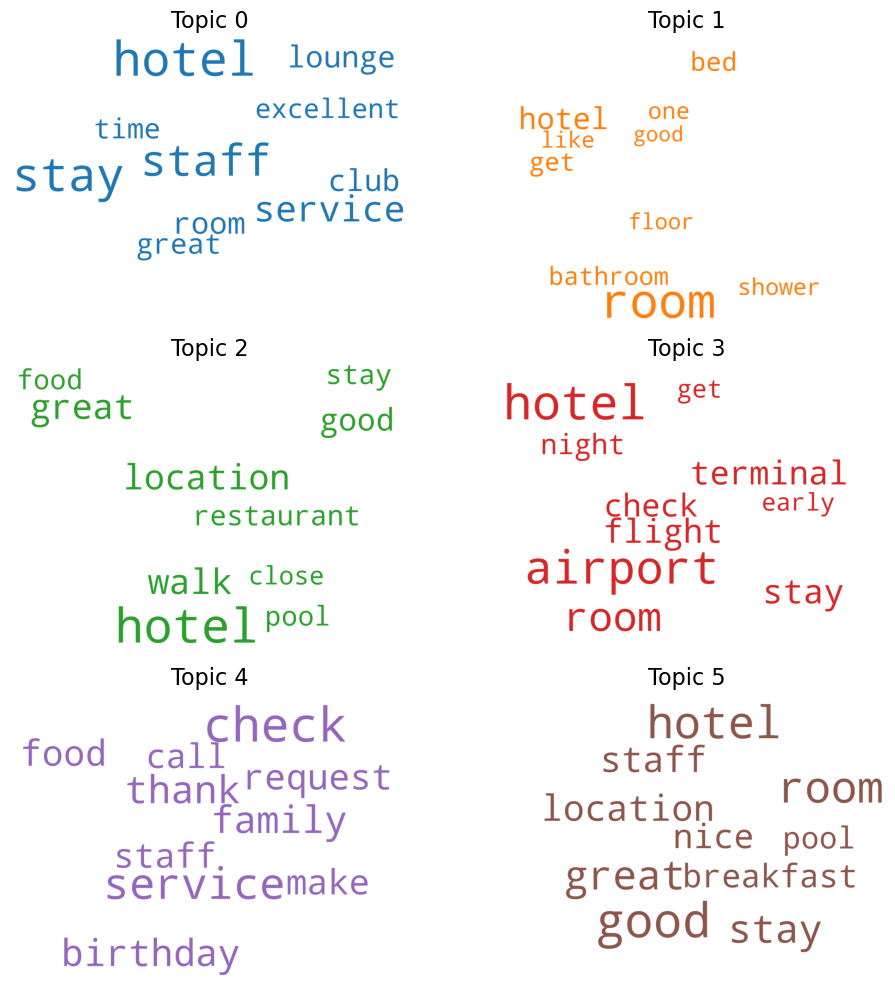

In [68]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the dataset
clouds_pre = []

for i in range(6):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(lem_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Plot the WordClouds for all topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [69]:
vis = pyLDAvis.gensim.prepare(topic_model=lem_ldamodel, corpus=lem_corpus, dictionary=lem_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Aspect Extraction

In [70]:
topics_stem

[(0,
  [('staff', 0.056477267),
   ('stay', 0.056220338),
   ('hotel', 0.054199193),
   ('great', 0.030717669),
   ('help', 0.027001219),
   ('room', 0.022609692),
   ('us', 0.02037837),
   ('excel', 0.01587406),
   ('thank', 0.013379024),
   ('would', 0.013280319),
   ('time', 0.012770084),
   ('love', 0.012261841),
   ('alway', 0.011937535),
   ('recommend', 0.011257271),
   ('clean', 0.010012149),
   ('back', 0.009985454),
   ('good', 0.009948766),
   ('make', 0.00988643),
   ('wonder', 0.008656625),
   ('check', 0.008453848)]),
 (1,
  [('hotel', 0.067087255),
   ('airport', 0.055225693),
   ('stay', 0.04099323),
   ('room', 0.03849012),
   ('flight', 0.027062232),
   ('termin', 0.026839312),
   ('night', 0.019860176),
   ('great', 0.018602977),
   ('check', 0.016537467),
   ('comfort', 0.0137295155),
   ('one', 0.012788036),
   ('good', 0.010861909),
   ('transit', 0.010651644),
   ('well', 0.010428565),
   ('walk', 0.009814563),
   ('would', 0.009599234),
   ('hour', 0.009182367),

In [71]:
top_dict = {}
for i in topics_stem:
    top_dict[i[0]] = []
    for j in i[1]:
        print(j)
        top_dict[i[0]].append(j[0])

('staff', 0.056477267)
('stay', 0.056220338)
('hotel', 0.054199193)
('great', 0.030717669)
('help', 0.027001219)
('room', 0.022609692)
('us', 0.02037837)
('excel', 0.01587406)
('thank', 0.013379024)
('would', 0.013280319)
('time', 0.012770084)
('love', 0.012261841)
('alway', 0.011937535)
('recommend', 0.011257271)
('clean', 0.010012149)
('back', 0.009985454)
('good', 0.009948766)
('make', 0.00988643)
('wonder', 0.008656625)
('check', 0.008453848)
('hotel', 0.067087255)
('airport', 0.055225693)
('stay', 0.04099323)
('room', 0.03849012)
('flight', 0.027062232)
('termin', 0.026839312)
('night', 0.019860176)
('great', 0.018602977)
('check', 0.016537467)
('comfort', 0.0137295155)
('one', 0.012788036)
('good', 0.010861909)
('transit', 0.010651644)
('well', 0.010428565)
('walk', 0.009814563)
('would', 0.009599234)
('hour', 0.009182367)
('next', 0.0090030655)
('overnight', 0.0088047)
('excel', 0.008602064)
('hotel', 0.06709426)
('great', 0.033090994)
('good', 0.032863263)
('walk', 0.022858094)

In [72]:
top_dict

{0: ['staff',
  'stay',
  'hotel',
  'great',
  'help',
  'room',
  'us',
  'excel',
  'thank',
  'would',
  'time',
  'love',
  'alway',
  'recommend',
  'clean',
  'back',
  'good',
  'make',
  'wonder',
  'check'],
 1: ['hotel',
  'airport',
  'stay',
  'room',
  'flight',
  'termin',
  'night',
  'great',
  'check',
  'comfort',
  'one',
  'good',
  'transit',
  'well',
  'walk',
  'would',
  'hour',
  'next',
  'overnight',
  'excel'],
 2: ['hotel',
  'great',
  'good',
  'walk',
  'stay',
  'room',
  'restaur',
  'pool',
  'food',
  'shop',
  'nice',
  'staff',
  'close',
  'place',
  'area',
  'also',
  'clean',
  'airport',
  'excel',
  'free'],
 3: ['club',
  'drink',
  'food',
  'breakfast',
  'also',
  'birthday',
  'view',
  'buffet',
  'th',
  'even',
  'enjoy',
  'suit',
  'floor',
  'us',
  'stay',
  'hotel',
  'cake',
  'dinner',
  'year',
  'bar'],
 4: ['room',
  'hotel',
  'check',
  'time',
  'book',
  'get',
  'one',
  'us',
  'ask',
  'day',
  'even',
  'stay',
  '

In [73]:
df_res = pd.DataFrame(top_dict)
df_res

0          1        2          3      4          5
0       staff      hotel    hotel       club   room       room
1        stay    airport    great      drink  hotel       good
2       hotel       stay     good       food  check       nice
3       great       room     walk  breakfast   time       pool
4        help     flight     stay       also   book      hotel
5        room     termin     room   birthday    get   bathroom
6          us      night  restaur       view    one        bed
7       excel      great     pool     buffet     us  breakfast
8       thank      check     food         th    ask     shower
9       would    comfort     shop       even    day      clean
10       time        one     nice      enjoy   even    comfort
11       love       good    staff       suit   stay      great
12      alway    transit    close      floor   desk       stay
13  recommend       well    place         us  would      small
14      clean       walk     area       stay  night      staff
15       back      would     also      hotel  could       well
16       good       hour    clean       cake   work       area
17       make       next  airport     dinner   need       bath
18     wonder  overnight    excel       year     go       size
19      check      excel     free        bar  floor       swim

In [18]:
df_res.to_csv('4-star LDA.csv')

## DP

In [26]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [27]:
# Pass in LDA topics output to remove overlap words by choosing highest prob
def restruct_topics(topics): 
    word_prob_dict = {}
    for i in range(len(topics)):
        topic_num = topics[i][0]
        for word, prob in topics[i][1]:
            if word in word_prob_dict:
                word_prob_dict[word].append((topic_num, prob))
            else:
                ls = [(topic_num, prob)]
                word_prob_dict[word] = ls
    new_dict = {}
    for word in word_prob_dict:
        topic, highest_prob = max(word_prob_dict[word], key = lambda x: x[1])
        if topic in new_dict:
            new_dict[topic].append(word)
        else:
            ls = [word]
            new_dict[topic] = ls
    return new_dict

In [28]:
new_dict = restruct_topics(topics_stem)

In [29]:
new_dict = restruct_topics(topics_stem)
for x in new_dict:
    print(f'length topic {x}: {len(new_dict[x])}')

length topic 4: 12
length topic 1: 11
length topic 0: 12
length topic 2: 13
length topic 3: 13
length topic 5: 13


In [30]:
#takes in the dataframe and appends to each row (aspect, review) pair(s)
def dep_parse(data, new_dict):
    data['aspect_sentiment'] = np.empty((len(data), 0)).tolist()
    for i in range(len(data)):
        sentence = data['combined_review'][i]
        doc = nlp(sentence)
        aspect_sentiment = []
        for word in doc:
            cond = False
            for x in new_dict.values():
                if word.text in x:
                    cond = True
                    break
            if not cond:
                continue
            if word.pos_ == 'NOUN': 
                for j in word.lefts:
                    #print(j, word, j.dep_, j.pos_)
                    if j.dep_ == 'amod' and j.pos_ == 'ADJ':
                        tup = [word, j, list(new_dict.values()).index(x)]
                        #print(tup)
                        aspect_sentiment.append(tup)
                    for k in j.lefts:
                        if k.dep_ == 'advmod':
                            #print(word, j ,k)
                            tup = (word, k.text + ' ' + j.text)
                            aspect_sentiment.append(tup)
                            if (word, j) in aspect_sentiment:
                                aspect_sentiment.remove([word, j, list(new_dict.values()).index(x)])
        data['aspect_sentiment'][i] = aspect_sentiment

In [24]:
df_filtered = df_filtered.reset_index()

In [25]:
dep_parse(df_filtered, new_dict)

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_15412\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_15412\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_15412\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [26]:
df_filtered['aspect_sentiment']

0                                 [[hotel, affordable, 1]]
1                                 [[room, comfortable, 2]]
2                                      [[place, right, 1]]
3                                           [[room, ️, 2]]
4        [[room, double, 2], [room, twin, 2], [hotel, d...
                               ...                        
18595    [[hotel, Excellent, 1], [hotel, amazing, 1], [...
18596    [[room, new, 2], [area, nice, 1], (area, Reall...
18597    [[hotel, cool, 1], (hotel, very cool), [hotel,...
18598                                                   []
18599                                 [[hotel, proper, 1]]
Name: aspect_sentiment, Length: 18600, dtype: object

## Import PyABSA

In [74]:
df_test = pd.read_json('../pyABSA_outputs/Aspect_Term_Extraction_and_Polarity_Classification_FAST_LCF_ATEPC.json')

In [75]:
df_test

sentence  \
0      clean comfort hotel room find decent hotel tra...   
1      good hotel great great place great room small ...   
2      good place decent price good place good price ...   
3      great great staff neat hotel line star rate st...   
4      good budget stay stay day nice seven eleven ne...   
...                                                  ...   
68287  swiss hotel swiss stay hotel mani time recent ...   
68288  stay stay night wife ideal view th floor floor...   
68289  great view great decent room one night hotel v...   
68290  hotel date old four night mani cup machin shop...   
68291  poor hotel book hotel brother oversea come spe...   

                                                     IOB  \
0      [O, B-ASP, O, O, O, O, O, O, O, B-ASP, O, O, O...   
1      [O, O, O, O, B-ASP, O, O, O, O, O, O, O, O, O,...   
2      [O, O, O, B-ASP, O, O, O, O, O, O, O, O, B-ASP...   
3      [O, O, B-ASP, O, O, O, O, O, O, B-ASP, I-ASP, ...   
4      [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...   
...                                                  ...   
68287  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...   
68288  [O, O, O, O, O, B-ASP, O, O, O, O, O, O, O, O,...   
68289  [O, B-ASP, O, O, B-ASP, O, O, O, O, O, O, O, O...   
68290  [O, O, O, O, O, O, O, O, O, O, O, O, O, B-ASP,...   
68291  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...   

                                                  tokens  \
0      [clean, comfort, hotel, room, find, decent, ho...   
1      [good, hotel, great, great, place, great, room...   
2      [good, place, decent, price, good, place, good...   
3      [great, great, staff, neat, hotel, line, star,...   
4      [good, budget, stay, stay, day, nice, seven, e...   
...                                                  ...   
68287  [swiss, hotel, swiss, stay, hotel, mani, time,...   
68288  [stay, stay, night, wife, ideal, view, th, flo...   
68289  [great, view, great, decent, room, one, night,...   
68290  [hotel, date, old, four, night, mani, cup, mac...   
68291  [poor, hotel, book, hotel, brother, oversea, c...   

                                           aspect  \
0      [comfort, food, glass, closet space, port]   
1                                         [place]   
2                                   [price, food]   
3                             [staff, front desk]   
4                                          [wait]   
...                                           ...   
68287                 [size, staff, porter, crew]   
68288                          [view, staff, air]   
68289                      [view, room, bathroom]   
68290                                [bed, cover]   
68291                         [floor, fruit, key]   

                               position  \
0      [[1], [9], [30], [37, 38], [47]]   
1                                 [[4]]   
2                           [[3], [12]]   
3                        [[2], [9, 10]]   
4                                [[18]]   
...                                 ...   
68287          [[15], [35], [67], [78]]   
68288                 [[5], [25], [45]]   
68289                  [[1], [4], [23]]   
68290                      [[13], [18]]   
68291                [[26], [31], [39]]   

                                               sentiment  \
0      [Positive, Negative, Negative, Negative, Negat...   
1                                             [Positive]   
2                                   [Positive, Negative]   
3                                   [Positive, Positive]   
4                                             [Positive]   
...                                                  ...   
68287           [Negative, Negative, Negative, Negative]   
68288                     [Positive, Positive, Positive]   
68289                     [Positive, Positive, Positive]   
68290                               [Positive, Positive]   
68291                     [Negative, Negative, Negative]   

          

In [76]:
df_json = df_test[df_test['sentence'].isin(list(df_filtered['stem_review']))]

In [77]:
len(df_json) == len(df_filtered) ##check if the number of elements is the same

True

In [78]:
df_json = df_json[['sentence', 'tokens', 'aspect', 'sentiment', 'confidence']]

In [79]:
df_json

sentence  \
14070  afford hotel afford pool bathtub mani bar arou...   
14071  good near airport quiet surround walk local fo...   
14072  concern stay hotel follow posit room need righ...   
14073  love room level staff excel room clean wonder ...   
14074  hotel told room book twin room accept unclean ...   
...                                                  ...   
32665  excel airport hotel hotel airport hotel access...   
32666  great view run way clean new room nice pool ar...   
32667  us review cool airport hotel new super clean n...   
32668  airport stay one night whilst return back impr...   
32669  good apart one thing hotel good proper hotel r...   

                                                  tokens  \
14070  [afford, hotel, afford, pool, bathtub, mani, b...   
14071  [good, near, airport, quiet, surround, walk, l...   
14072  [concern, stay, hotel, follow, posit, room, ne...   
14073  [love, room, level, staff, excel, room, clean,...   
14074  [hotel, told, room, book, twin, room, accept, ...   
...                                                  ...   
32665  [excel, airport, hotel, hotel, airport, hotel,...   
32666  [great, view, run, way, clean, new, room, nice...   
32667  [us, review, cool, airport, hotel, new, super,...   
32668  [airport, stay, one, night, whilst, return, ba...   
32669  [good, apart, one, thing, hotel, good, proper,...   

                                            aspect  \
14070                                 [bar, staff]   
14071                               [comfort room]   
14072  [mirror, seat area, view sea room, comfort]   
14073                            [staff, sea view]   
14074                               [sound, price]   
...                                            ...   
32665    [excel, bathroom shower room, gym, staff]   
32666           [view, new room, pool area, staff]   
32667                         [common area, staff]   
32668                                [staff, club]   
32669                      [clean room, breakfast]   

                                      sentiment  \
14070                       [Neutral, Positive]   
14071                                [Positive]   
14072  [Negative, Negative, Positive, Positive]   
14073                       [Neutral, Positive]   
14074                      [Negative, Negative]   
...                                         ...   
32665   [Neutral, Positive, Positive, Positive]   
32666   [Positive, Positive, Positive, Neutral]   
32667                      [Positive, Positive]   
32668                       [Positive, Neutral]   
32669                       [Positive, Neutral]   

                                              confidence  
14070                                   [0.9977, 0.9989]  
14071                                           [0.9995]  
14072                   [0.8882, 0.5642, 0.8084, 0.9483]  
14073                                   [0.5905, 0.9995]  
14074                       [0.9984000000000001, 0.9978]  
...                                                  ...  
32665  [0.5416000000000001, 0.9936, 0.9965, 0.9912000...  
32666  [0.9981000000000001, 0.9993000000000001, 0.999...  
32667                       [0.9867, 0.9994000000000001]  
32668                       [0.9971000000000001, 0.9975]  
32669                       [0.9978, 0.9328000000000001]  

[18600 rows x 5 columns]

## Get PyABSA topics

In [80]:
def get_topics(lst, dictionary, sentiment, confidence, topics_list, vectorizer, transformer, model):
    ans = []
    for word in range(len(lst)):
        docbow = dictionary.doc2bow([lst[word]])
        if len(docbow) == 0:
            tpc = get_cosine_similarity(lst[word], topics_list, vectorizer, transformer)
            res = (tpc, sentiment[word], confidence[word])
        else:
            tpc = model.get_document_topics(docbow)
            new_tpc = []
            max_val = 0
            max_tpc = -1
            for c, v in tpc:
                if v > max_val:
                    max_val = v
                    max_tpc = c
            res = (max_tpc, sentiment[word], confidence[word])
        ans.append(res)
    return ans

In [81]:
def get_cosine_similarity(word, topics_list, vectorizer, transformer):
    aspect_vec = vectorizer.transform([word])
    aspect_trf = transformer.transform(aspect_vec)
    cos_res = {}
    for i in range(len(topics_list.columns)):
        topic_words_vec = vectorizer.transform(list(topics_list[i]))
        topic_words_trf = transformer.transform(topic_words_vec)
        r = cosine_similarity(aspect_trf, topic_words_trf)
        cos_sim = np.rad2deg(np.arccos(r))
        
        mid_res = []
        for j in cos_sim:
            min_cos_sim = min(j)
            mid_res.append(min_cos_sim)
        cos_res[i] = mid_res
    min_val = 90
    min_topic = -1
    for k, v in cos_res.items():
        if v[0] < min_val:
            min_val = v
            min_topic = k
    return k

In [82]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
import scipy.sparse

In [83]:
df_filtered['vec_tokens'] = df_filtered['stem_tokens'].apply(lambda x: ' '.join(x))

In [84]:
vectorizer = CountVectorizer()
transformer = TfidfTransformer()

filtered_vec = vectorizer.fit_transform(df_filtered['vec_tokens'])
filtered_trf = transformer.fit_transform(filtered_vec)

In [85]:
df_json['topics'] = np.empty((len(df_json), 0)).tolist()

In [86]:
df_json

sentence  \
14070  afford hotel afford pool bathtub mani bar arou...   
14071  good near airport quiet surround walk local fo...   
14072  concern stay hotel follow posit room need righ...   
14073  love room level staff excel room clean wonder ...   
14074  hotel told room book twin room accept unclean ...   
...                                                  ...   
32665  excel airport hotel hotel airport hotel access...   
32666  great view run way clean new room nice pool ar...   
32667  us review cool airport hotel new super clean n...   
32668  airport stay one night whilst return back impr...   
32669  good apart one thing hotel good proper hotel r...   

                                                  tokens  \
14070  [afford, hotel, afford, pool, bathtub, mani, b...   
14071  [good, near, airport, quiet, surround, walk, l...   
14072  [concern, stay, hotel, follow, posit, room, ne...   
14073  [love, room, level, staff, excel, room, clean,...   
14074  [hotel, told, room, book, twin, room, accept, ...   
...                                                  ...   
32665  [excel, airport, hotel, hotel, airport, hotel,...   
32666  [great, view, run, way, clean, new, room, nice...   
32667  [us, review, cool, airport, hotel, new, super,...   
32668  [airport, stay, one, night, whilst, return, ba...   
32669  [good, apart, one, thing, hotel, good, proper,...   

                                            aspect  \
14070                                 [bar, staff]   
14071                               [comfort room]   
14072  [mirror, seat area, view sea room, comfort]   
14073                            [staff, sea view]   
14074                               [sound, price]   
...                                            ...   
32665    [excel, bathroom shower room, gym, staff]   
32666           [view, new room, pool area, staff]   
32667                         [common area, staff]   
32668                                [staff, club]   
32669                      [clean room, breakfast]   

                                      sentiment  \
14070                       [Neutral, Positive]   
14071                                [Positive]   
14072  [Negative, Negative, Positive, Positive]   
14073                       [Neutral, Positive]   
14074                      [Negative, Negative]   
...                                         ...   
32665   [Neutral, Positive, Positive, Positive]   
32666   [Positive, Positive, Positive, Neutral]   
32667                      [Positive, Positive]   
32668                       [Positive, Neutral]   
32669                       [Positive, Neutral]   

                                              confidence topics  
14070                                   [0.9977, 0.9989]     []  
14071                                           [0.9995]     []  
14072                   [0.8882, 0.5642, 0.8084, 0.9483]     []  
14073                                   [0.5905, 0.9995]     []  
14074                       [0.9984000000000001, 0.9978]     []  
...                                                  ...    ...  
32665  [0.5416000000000001, 0.9936, 0.9965, 0.9912000...     []  
32666  [0.9981000000000001, 0.9993000000000001, 0.999...     []  
32667                       [0.9867, 0.9994000000000001]     []  
32668                       [0.9971000000000001, 0.9975]     []  
32669                       [0.9978, 0.9328000000000001]     []  

[18600 rows x 6 columns]

In [87]:
for i, r in df_json.iterrows():
    asp = r['aspect']
    sent = r['sentiment']
    confid = r['confidence']
    tpc = get_topics(asp, stem_dict, sent, confid, df_res, vectorizer, transformer, stem_ldamodel)
    tpcs = r['topics']
    for i in tpc:
        tpcs.append(i)
    r['topics'] = tpcs

In [88]:
print(f"The number of reviews without any topics is {sum(df_json['topics'].apply(lambda x: len(x) == 0))}")
print(f"The number of reviews with exactly one topic is {sum(df_json['topics'].apply(lambda x: len(x) == 1))}")
print(f"The number of reviews with more than one topic is {sum(df_json['topics'].apply(lambda x: len(x) > 1))}")

The number of reviews without any topics is 700
The number of reviews with exactly one topic is 4712
The number of reviews with more than one topic is 13188


In [89]:
df_json

sentence  \
14070  afford hotel afford pool bathtub mani bar arou...   
14071  good near airport quiet surround walk local fo...   
14072  concern stay hotel follow posit room need righ...   
14073  love room level staff excel room clean wonder ...   
14074  hotel told room book twin room accept unclean ...   
...                                                  ...   
32665  excel airport hotel hotel airport hotel access...   
32666  great view run way clean new room nice pool ar...   
32667  us review cool airport hotel new super clean n...   
32668  airport stay one night whilst return back impr...   
32669  good apart one thing hotel good proper hotel r...   

                                                  tokens  \
14070  [afford, hotel, afford, pool, bathtub, mani, b...   
14071  [good, near, airport, quiet, surround, walk, l...   
14072  [concern, stay, hotel, follow, posit, room, ne...   
14073  [love, room, level, staff, excel, room, clean,...   
14074  [hotel, told, room, book, twin, room, accept, ...   
...                                                  ...   
32665  [excel, airport, hotel, hotel, airport, hotel,...   
32666  [great, view, run, way, clean, new, room, nice...   
32667  [us, review, cool, airport, hotel, new, super,...   
32668  [airport, stay, one, night, whilst, return, ba...   
32669  [good, apart, one, thing, hotel, good, proper,...   

                                            aspect  \
14070                                 [bar, staff]   
14071                               [comfort room]   
14072  [mirror, seat area, view sea room, comfort]   
14073                            [staff, sea view]   
14074                               [sound, price]   
...                                            ...   
32665    [excel, bathroom shower room, gym, staff]   
32666           [view, new room, pool area, staff]   
32667                         [common area, staff]   
32668                                [staff, club]   
32669                      [clean room, breakfast]   

                                      sentiment  \
14070                       [Neutral, Positive]   
14071                                [Positive]   
14072  [Negative, Negative, Positive, Positive]   
14073                       [Neutral, Positive]   
14074                      [Negative, Negative]   
...                                         ...   
32665   [Neutral, Positive, Positive, Positive]   
32666   [Positive, Positive, Positive, Neutral]   
32667                      [Positive, Positive]   
32668                       [Positive, Neutral]   
32669                       [Positive, Neutral]   

                                              confidence  \
14070                                   [0.9977, 0.9989]   
14071                                           [0.9995]   
14072                   [0.8882, 0.5642, 0.8084, 0.9483]   
14073                                   [0.5905, 0.9995]   
14074                       [0.9984000000000001, 0.9978]   
...                                                  ...   
32665  [0.5416000000000001, 0.9936, 0.9965, 0.9912000...   
32666  [0.9981000000000001, 0.9993000000000001, 0.999...   
32667                       [0.9867, 0.9994000000000001]   
32668                       [0.9971000000000001, 0.9975]   
32669                       [0.9978, 0.9328000000000001]   

                                                  topics  
14070      [(3, Neutral, 0.9977), (0, Positive, 0.9989)]  
14071                            [(5, Positive, 0.9995)]  
14072  [(4, Negative, 0.8882), (5, Negative, 0.5642),...  
14073      [(0, Neutral, 0.5905), (5, Positive, 0.9995)]  
14074  [(5, Negative, 0.9984000000000001), (2, Negati...  
...                                                  ...  
32665  [(0, Neutral, 0.5416000000000001), (5, Positiv...  
32666  [(3, Positive, 0.9981000000000001), (5, Positi...  
32667  [(5, Positive, 0.9867), (0, Positive, 0.999400...  
32668  [(0, Positive, 0.997100000

In [90]:
df_json['topics'][14071]

[(5, 'Positive', 0.9995)]

In [37]:
df_json.to_csv('4star_pyABSA_updated.csv')